In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score

## Содержание:
+ Предварительный анализ данных
    + Удаление пропущенных значений
    + Проверка сбалансированности целевой переменной
+ Подготовка данных
    + Кодирование текстовых полей
    + Корреляции
    + Масштабирование
+ Обучение
    + Выбор моделей
    + Последовательные GridSearch'ы по параметрам
    + Оценка качества

### Предварительный анализ данных

In [2]:
X_raw = pd.read_csv("avia_clients.csv")

In [3]:
X_raw.head()

,id,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction
0,1,Male,48.0,disloyal Customer,Business travel,Business,821.0,2.0,5.0,3.0,...,3.0,5.0,5.0,3.0,2.0,5.0,4.0,5.0,5.0,neutral or dissatisfied
1,2,Female,35.0,Loyal Customer,Business travel,Business,821.0,26.0,39.0,2.0,...,5.0,4.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,satisfied
2,3,Male,41.0,Loyal Customer,Business travel,Business,853.0,0.0,0.0,4.0,...,5.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,5.0,satisfied
3,4,Male,50.0,Loyal Customer,Business travel,Business,1905.0,0.0,0.0,2.0,...,4.0,5.0,5.0,5.0,5.0,5.0,3.0,5.0,4.0,satisfied
4,5,Female,49.0,Loyal Customer,Business travel,Business,3470.0,0.0,1.0,3.0,...,5.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,5.0,satisfied


In [4]:
X_raw.shape

(129880, 24)

In [5]:
X_raw['satisfaction'].value_counts() # есть объекты с пропущенной целевой переменной - удалить

neutral or dissatisfied    58879
satisfied                  45025
-                          25976
Name: satisfaction, dtype: int64

In [6]:
X_raw = X_raw[X_raw['satisfaction'] != '-']
X_raw['satisfaction'] = X_raw['satisfaction'].apply(lambda x: 1 if x == 'satisfied' else 0) # переводим в 0 / 1
print(X_raw.shape)

(103904, 24)


0    58879
1    45025
Name: satisfaction, dtype: int64


Text(0.5, 1.0, 'Class counts (checking for imbalance)')

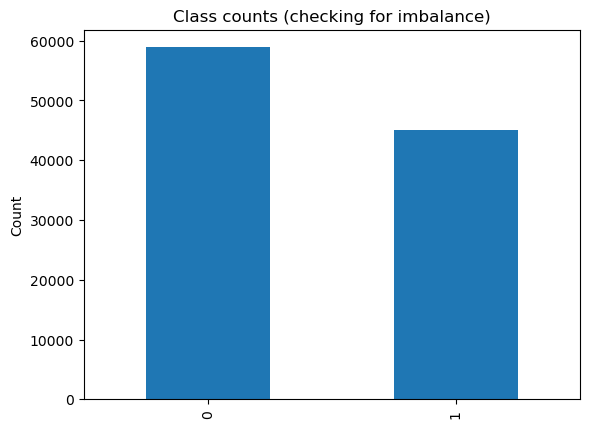

In [7]:
# Классы достаточно сбалансированы? - да 
print(X_raw['satisfaction'].value_counts())
X_raw['satisfaction'].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Class counts (checking for imbalance)')

In [8]:
# Пропущенные значения
for column in X_raw.columns:
    if X_raw[column].isna().sum() != 0:
        print(column, X_raw[column].isna().sum())

Gender 260
Age 261
Customer Type 66
Type of Travel 88
Class 89
Flight Distance 72
Departure Delay in Minutes 84
Arrival Delay in Minutes 407
Inflight wifi service 33
Departure/Arrival time convenient 41
Ease of Online booking 33
Gate location 31
Food and drink 35
Online boarding 37
Seat comfort 41
Inflight entertainment 44
On-board service 32
Leg room service 36
Baggage handling 32
Checkin service 34
Inflight service 49
Cleanliness 31


In [9]:
X_clean = X_raw.dropna() # доля объектов с пропущенными значениями небольшая - удаляем

In [10]:
X_clean.shape

(102085, 24)

In [11]:
# Возможные значения строковых признаков
for column in X_clean.columns:
    if X_clean[column].dtype == 'object':
        print(column, set(X_clean[column]))
        print(X_clean[column].value_counts())
        print()

Gender {'Male', 'Female'}
Female    51830
Male      50255
Name: Gender, dtype: int64

Customer Type {'disloyal Customer', 'Loyal Customer'}
Loyal Customer       83434
disloyal Customer    18651
Name: Customer Type, dtype: int64

Type of Travel {'Personal Travel', 'Business travel'}
Business travel    70408
Personal Travel    31677
Name: Type of Travel, dtype: int64

Class {'Eco', 'Eco Plus', 'Business'}
Business    48795
Eco         45931
Eco Plus     7359
Name: Class, dtype: int64



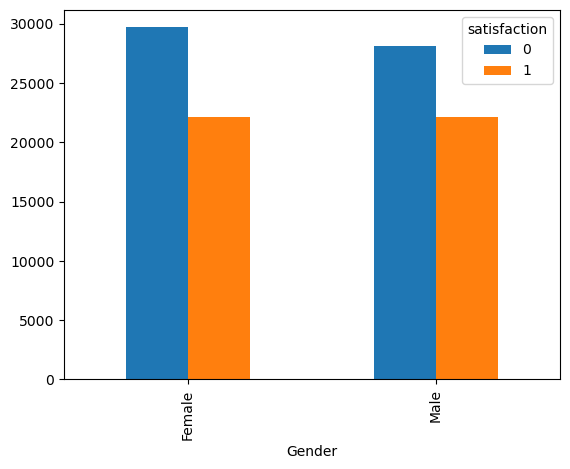

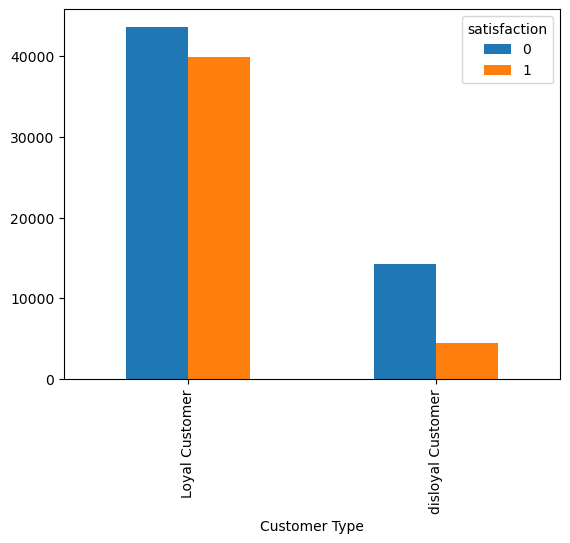

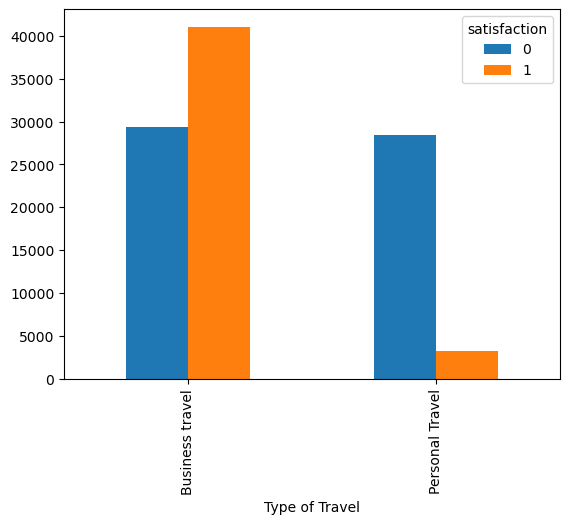

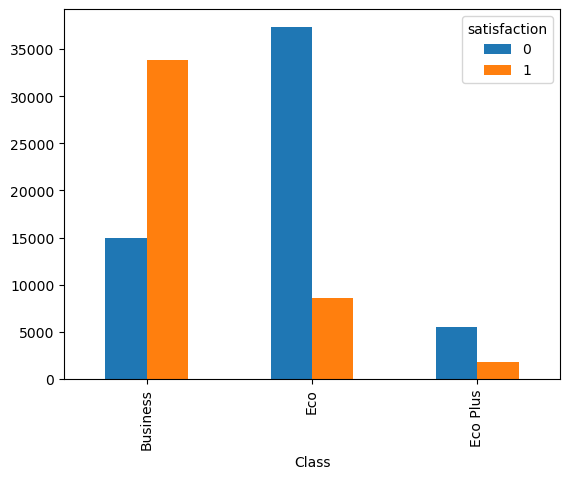

In [12]:
for column in X_clean.columns:
    if X_clean[column].dtype == 'object':
        X_clean.pivot_table('id', column, 'satisfaction', 'count').plot(kind='bar')

**Выводы:** достаточно сбалансированное распределение целевой переменной, категориальные признаки с небольшой вариацией возможных значений => можно применить one-hot encoding. По категориальным признакам: наиболее значимы Type of Travel, Class.

### Подготовка данных

In [13]:
X_clean = pd.get_dummies(X_clean, drop_first=True) # one-hot encoding

In [14]:
X_clean.shape

(102085, 25)

In [15]:
X_clean.head()

,id,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,...,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus
0,1,48.0,821.0,2.0,5.0,3.0,3.0,3.0,3.0,5.0,...,5.0,4.0,5.0,5.0,0,1,1,0,0,0
1,2,35.0,821.0,26.0,39.0,2.0,2.0,2.0,2.0,3.0,...,5.0,3.0,5.0,5.0,1,0,0,0,0,0
2,3,41.0,853.0,0.0,0.0,4.0,4.0,4.0,4.0,5.0,...,3.0,4.0,3.0,5.0,1,1,0,0,0,0
3,4,50.0,1905.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,...,5.0,3.0,5.0,4.0,1,1,0,0,0,0
4,5,49.0,3470.0,0.0,1.0,3.0,3.0,3.0,3.0,4.0,...,3.0,3.0,3.0,5.0,1,0,0,0,0,0


In [16]:
y = X_clean['satisfaction']
X = X_clean.drop(['satisfaction', 'id'], axis=1)

In [17]:
X.head()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus
0,48.0,821.0,2.0,5.0,3.0,3.0,3.0,3.0,5.0,3.0,...,2.0,5.0,4.0,5.0,5.0,1,1,0,0,0
1,35.0,821.0,26.0,39.0,2.0,2.0,2.0,2.0,3.0,5.0,...,5.0,5.0,3.0,5.0,5.0,0,0,0,0,0
2,41.0,853.0,0.0,0.0,4.0,4.0,4.0,4.0,5.0,5.0,...,3.0,3.0,4.0,3.0,5.0,1,0,0,0,0
3,50.0,1905.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,4.0,...,5.0,5.0,3.0,5.0,4.0,1,0,0,0,0
4,49.0,3470.0,0.0,1.0,3.0,3.0,3.0,3.0,4.0,5.0,...,4.0,3.0,3.0,3.0,5.0,0,0,0,0,0


In [18]:
X.corrwith(y)

Age                                  0.106338
Flight Distance                      0.076566
Departure Delay in Minutes          -0.028545
Arrival Delay in Minutes            -0.020372
Inflight wifi service                0.278414
Departure/Arrival time convenient   -0.052263
Ease of Online booking               0.168113
Gate location                        0.000106
Food and drink                       0.203882
Online boarding                      0.490779
Seat comfort                         0.342014
Inflight entertainment               0.391229
On-board service                     0.312278
Leg room service                     0.303307
Baggage handling                     0.239223
Checkin service                      0.228206
Inflight service                     0.238718
Cleanliness                          0.297821
Gender_Male                          0.012666
Customer Type_disloyal Customer     -0.187713
Type of Travel_Personal Travel      -0.448906
Class_Eco                         

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [20]:
normalizer = preprocessing.StandardScaler().fit(X_train)
columns = X.columns
X_train = pd.DataFrame(data=normalizer.transform(X_train))
X_test = pd.DataFrame(data=normalizer.transform(X_test))
X_train.columns = columns
X_test.columns = columns
X_train.head()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Gender_Male,Customer Type_disloyal Customer,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus
0,-0.248408,0.212874,-0.228375,-0.158876,-1.280067,-0.044323,-0.537836,0.016216,-0.151013,-0.901539,...,-1.719951,0.295811,-1.000156,0.291334,-0.214402,-0.983552,-0.474051,1.488956,1.103810,-0.279852
1,0.493442,-0.047933,-0.228375,-0.158876,0.937372,0.595021,0.873957,0.784121,-1.618315,0.534985,...,0.472828,0.295811,-1.000156,0.291334,-1.700646,-0.983552,-0.474051,-0.671612,1.103810,-0.279852
2,1.383663,0.569733,-0.228375,-0.158876,-1.280067,-1.323012,-1.243733,-1.519594,-0.151013,0.534985,...,0.472828,0.295811,0.524183,0.291334,0.528720,1.016723,-0.474051,-0.671612,-0.905953,-0.279852
3,1.037466,-0.014457,-0.199148,-0.158876,0.198226,1.234365,0.168060,-0.751689,0.582637,-0.183277,...,0.472828,1.112248,-0.237987,1.113873,0.528720,1.016723,-0.474051,1.488956,1.103810,-0.279852
4,-0.248408,0.112446,1.028398,0.746468,0.198226,0.595021,0.168060,0.016216,1.316288,-0.183277,...,-0.258099,-0.520626,1.286352,1.113873,1.271842,-0.983552,-0.474051,1.488956,1.103810,-0.279852


**Выводы:** по корреляции: почти все оценки клиентов важны; также важны тип поездки и лояльность клиента. Длительность перелета и задержки менее важны. Пол клиента не важен.

### Обучение

Используемые модели: метод опорных векторов (SVM) и градиентный бустинг.

Модели бинарных классификаторов: простейшие (KNN, 'наивная' классификация), SVM / логистическая регрессия, случайный лес / градиентный бустинг.

SVM / логистическая регрессия: SVM лучше для линейно неразделимых случаев.

Случайный лес / градиентный бустинг: у бустинга более высокий результат на сложных данных (уменьшение смещения), но нужно избегать переобучения. В качестве бустинга берется XGBoost.

**Оценка качества:** так как количество объектов с разным значением целевой переменной сопоставимо друг с другом, можно использовать accuracy. Также возьмем f1 меру (гармоническое среднее precision и recall).

**Метод опорных векторов**

In [21]:
svm = SVC()

In [22]:
param_test1 = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [0.5, 1, 1.5]
}

gsearch1 = GridSearchCV(estimator=svm, 
                        param_grid=param_test1,
                        scoring='accuracy',
                        n_jobs=-1,
                        cv=5)

gsearch1.fit(X_train, y_train)

gsearch1.best_params_

{'C': 1.5, 'kernel': 'rbf'}

In [23]:
svm.set_params(**gsearch1.best_params_)

SVC(C=1.5)

In [24]:
param_test2 = {
    'gamma': ['scale', 'auto'],
    'tol': [0.0001, 0.001, 0.01]
}

gsearch2 = GridSearchCV(estimator=svm, 
                        param_grid=param_test2,
                        scoring='accuracy',
                        n_jobs=-1,
                        cv=5)

gsearch2.fit(X_train, y_train)

gsearch2.best_params_

{'gamma': 'scale', 'tol': 0.01}

In [25]:
svm.set_params(**gsearch2.best_params_)

SVC(C=1.5, tol=0.01)

In [26]:
svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test)

**Градиентный бустинг**

In [27]:
gb = XGBClassifier()

In [28]:
param_test1 = {
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 300, 400]
}

gsearch1 = GridSearchCV(estimator=gb, 
                        param_grid=param_test1,
                        scoring='accuracy',
                        n_jobs=-1,
                        cv=5)

gsearch1.fit(X_train, y_train)

gsearch1.best_params_

{'learning_rate': 0.1, 'n_estimators': 300}

In [29]:
gb.set_params(**gsearch1.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [30]:
param_test2 = {
    'max_depth': [2, 4, 6],
    'min_child_weight': [1, 2, 3]
}

gsearch2 = GridSearchCV(estimator=gb, 
                        param_grid=param_test2,
                        scoring='accuracy',
                        n_jobs=-1,
                        cv=5)

gsearch2.fit(X_train, y_train)

gsearch2.best_params_

{'max_depth': 6, 'min_child_weight': 1}

In [31]:
gb.set_params(**gsearch2.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [32]:
param_test3 = {
    'subsample': [0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1]
}

gsearch3 = GridSearchCV(estimator=gb, 
                        param_grid=param_test3,
                        scoring='accuracy',
                        n_jobs=-1,
                        cv=5)

gsearch3.fit(X_train, y_train)

gsearch3.best_params_

{'colsample_bytree': 0.9, 'subsample': 0.9}

In [33]:
gb.set_params(**gsearch3.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [34]:
param_test4 = {
    'gamma': [0.1, 0.25, 0.5, 0.75, 1],
    'reg_alpha': [1e-7, 1e-5, 1e-2, 1]
}

gsearch4 = GridSearchCV(estimator=gb, 
                        param_grid=param_test4,
                        scoring='accuracy',
                        n_jobs=-1,
                        cv=5)

gsearch4.fit(X_train, y_train)

gsearch4.best_params_

{'gamma': 0.25, 'reg_alpha': 1e-05}

In [35]:
gb.set_params(**gsearch4.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [36]:
gb.fit(X_train, y_train)
pred_gb = gb.predict(X_test)

**Оценка качества:** так как количество объектов с разным значением целевой переменной сопоставимо друг с другом, можно использовать accuracy. Также возьмем f1 меру (гармоническое среднее precision и recall).

In [39]:
print('SVM accuracy:', accuracy_score(pred_svm, y_test))
print('Gradient boosting accuracy:', accuracy_score(pred_gb, y_test))

SVM accuracy: 0.952883171161758
Gradient boosting accuracy: 0.9630705936132697


In [40]:
print('SVM f1-score:', f1_score(pred_svm, y_test))
print('Gradient boosting f1-score:', f1_score(pred_gb, y_test))

SVM f1-score: 0.9451851851851851
Gradient boosting f1-score: 0.9569224909541041


**Вывод**: градиентный бустинг незначительно превосходит SVM.